#  Object Detection Colab





## Imports

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 3.2 kB/s 
     |████████████████████████████████| 2.9 MB 42.3 MB/s 
     |████████████████████████████████| 26.1 MB 2.4 MB/s 
     |████████████████████████████████| 454 kB 45.5 MB/s 
     |████████████████████████████████| 3.0 MB 33.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Unins

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3451, done.
remote: Counting objects: 100% (3451/3451), done.
remote: Compressing objects: 100% (2892/2892), done.
remote: Total 3451 (delta 896), reused 1480 (delta 502), pack-reused 0
Receiving objects: 100% (3451/3451), 46.92 MiB | 31.42 MiB/s, done.
Resolving deltas: 100% (896/896), done.


In [ ]:
pathlib.Path.cwd().parts
'training_demo' in pathlib.Path.cwd().parts


False

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1694955 sha256=44304f5156d82fb6b1fbae58e8fc2061cc813a32ef198d8ca6ae0731381a2db4
  Stored in directory: /tmp/pip-ephem-wheel-cache-hjwprbmi/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=585bfe644267103ce81e93df41800ca3ab2e107a4a3a5e9e401cb452ce498c4e
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=1d38ed86737250903988a513078ce6b3650e575dfd6fc3308fdbe8ca0ed57490
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_p

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.4.1 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.1.0 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
!unrar x '/content/women.rar' # "/content/people"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/women.rar

Creating    women                                                     OK
Creating    women/test                                                OK
Extracting  women/test/a11.jpg                                             5%  OK 
Extracting  women/test/a13.jpg                                            10%  OK 
Extracting  women/test/a15.jpg                                            14%  OK 
Extracting  women/test/a19.jpg                                            19%  OK 
Extracting  women/test/a20.jpg                                            25%  OK 
Creating    women/train                                               OK
Extracting  women/train/a1.jpg                                            32%  OK 
Extracting  women/train/a10.jpg                                           37%  OK 
Extracting  women/train/a12.jpg 

# Utilities

In [ ]:
def load_image_into_numpy_array(path):
  
   """Load an image from file into a numpy array.

   Args:
    path: a file path.

   Returns:
     uint8 numpy array with shape (img_height, img_width, 3)
   """
   img_data = tf.io.gfile.GFile(path, 'rb').read()

   image = Image.open(BytesIO(img_data))

   (im_width, im_height) = image.size

   return np.array(image.getdata()).reshape(
           (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np, boxes, classes, scores,  category_index,
                    figsize=(12, 16), image_name=None):
  
   """Wrapper function to visualize detections.

   Args:
     image_np: uint8 numpy array with shape (img_height, img_width, 3)
     boxes: a numpy array of shape [N, 4]
     classes: a numpy array of shape [N]. Note that class indices are 1-based,
       and match the keys in the label map.
     scores: a numpy array of shape [N] or None.  If scores=None, then
       this function assumes that the boxes to be plotted are groundtruth
       boxes and plot all boxes as black with no classes or scores.
     category_index: a dict containing category dictionaries (each holding
       category index `id` and category name `name`) keyed by category indices.
     figsize: size for the figure.
     image_name: a name for the image file.
   """
  
   image_np_with_annotations = image_np.copy()

   viz_utils.visualize_boxes_and_labels_on_image_array(       
        image_np_with_annotations,
        boxes,  classes,
        scores, category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
  
   if image_name:
     plt.imsave(image_name, image_np_with_annotations)
   else:
     plt.imshow(image_np_with_annotations)


##select training images


In [ ]:
image_dir = '/content/women/train'

# number of pictu 
train_pic = sorted(os.listdir(image_dir)) # dir is your directory path
print(len(train_pic) )
print(train_pic)


13
['a1.jpg', 'a10.jpg', 'a12.jpg', 'a14.jpg', 'a16.jpg', 'a17.jpg', 'a18.jpg', 'a2.jpg', 'a3.jpg', 'a4.jpg', 'a7.jpg', 'a8.jpg', 'a9.jpg']


# data



In [ ]:
# Load images
train_image_dir = '/content/women/train'

train_images_np = []

for img in train_pic : # range(number_picture):

    image_path = os.path.join(train_image_dir, img)
    print(f"image is : {img}")  
    train_images_np.append(load_image_into_numpy_array(image_path))

#print(image_path)

image is : a1.jpg
image is : a10.jpg
image is : a12.jpg
image is : a14.jpg
image is : a16.jpg
image is : a17.jpg
image is : a18.jpg
image is : a2.jpg
image is : a3.jpg
image is : a4.jpg
image is : a7.jpg
image is : a8.jpg
image is : a9.jpg


In [ ]:
len(train_images_np)

13

#create boxes from text file

2.   we use this cell when we have annotation Cordinate




In [ ]:
"""
bolt_pos_path = '/content/result10.txt'

box=[]
#counter=0
c=[]

with open(bolt_pos_path ,'r') as f:
    while True:
       line= f.readline()
       select=line[:11]
       if select in picturesList[:30] :
          b= line[11:].split()
          for x in b:
            x= x[:-2]
            c.append(x)
       
          box.append(c)
         # counter += 1
          c=[]
       
       if not line :
          break


string_to_number_list = []
gt_boxes_first = []

for bolt_pos in box: 
    for string in bolt_pos:
        string_to_number = list( np.fromstring(string, sep=',') )
        string_to_number_list.append(string_to_number )

    #gt_boxes_first.append(string_to_number)
   # gt_boxes_first.append( np.array(string_to_number,dtype=np.float32).reshape(1,4) )

    gt_boxes_first.append( np.array(string_to_number_list,dtype=np.float32) )# *0.001 )#.reshape(1,4) )
    string_to_number_list = []  

 
L_change=[]
gt_boxes=[]
mid=[]

for ar in gt_boxes_first :
   for item in ar :
      for i in range (4):
         if i% 2== 0:
            L_change.append(item[i+1]/train_images_np[0].shape[0])
         else:
            L_change.append(item[i-1]/train_images_np[0].shape[1])
      mid.append(L_change) 
      L_change=[]            
   gt_boxes.append(np.array(mid) ) 
   mid=[] 
  """

"\nbolt_pos_path = '/content/result10.txt'\n\nbox=[]\n#counter=0\nc=[]\n\nwith open(bolt_pos_path ,'r') as f:\n    while True:\n       line= f.readline()\n       select=line[:11]\n       if select in picturesList[:30] :\n          b= line[11:].split()\n          for x in b:\n            x= x[:-2]\n            c.append(x)\n       \n          box.append(c)\n         # counter += 1\n          c=[]\n       \n       if not line :\n          break\n\n\nstring_to_number_list = []\ngt_boxes_first = []\n\nfor bolt_pos in box: \n    for string in bolt_pos:\n        string_to_number = list( np.fromstring(string, sep=',') )\n        string_to_number_list.append(string_to_number )\n\n    #gt_boxes_first.append(string_to_number)\n   # gt_boxes_first.append( np.array(string_to_number,dtype=np.float32).reshape(1,4) )\n\n    gt_boxes_first.append( np.array(string_to_number_list,dtype=np.float32) )# *0.001 )#.reshape(1,4) )\n    string_to_number_list = []  \n\n \nL_change=[]\ngt_boxes=[]\nmid=[]\n\nfor 

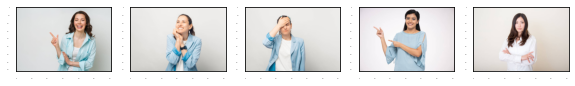

In [ ]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

#plt.imshow(train_images_np[5])

for idx, train_image_np in enumerate(train_images_np[:5]):
  plt.subplot(2,7, idx+1)
  plt.imshow(train_image_np)
plt.show()


In [ ]:
train_image_np.shape

(408, 612, 3)

# Annotate images with Colab



In [ ]:
gt_boxes_init = []
colab_utils.annotate(train_images_np, box_storage_pointer= gt_boxes_init)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

# Bounding Boxes 

In [ ]:
gt_boxes_init

[array([[0.03940104, 0.40522876, 0.94773438, 0.84150327]]),
 array([[0.09443287, 0.37091503, 0.99443287, 0.75326797]]),
 array([[0.10609954, 0.19281046, 0.98609954, 0.65686275]]),
 array([[0.0277662 , 0.22222222, 0.98943287, 0.71568627]]),
 array([[0.0827662 , 0.28267974, 0.9727662 , 0.66666667]]),
 array([[0.06443287, 0.21078431, 0.99109954, 0.56535948]]),
 array([[0.04609954, 0.32843137, 0.98109954, 0.76470588]]),
 array([[0.05443287, 0.30718954, 0.98109954, 0.71895425]]),
 array([[0.08109954, 0.11437908, 0.9877662 , 0.84803922]]),
 array([[0.03943287, 0.23039216, 0.98109954, 0.7369281 ]]),
 array([[0.06443287, 0.26633987, 0.9927662 , 0.78431373]]),
 array([[0.1827662 , 0.2875817 , 0.97943287, 0.71568627]]),
 array([[0.05609954, 0.34477124, 0.98609954, 0.79411765]])]

# delet extra box
maybe in making bounding box in colab we have repetetive box

In [ ]:

gt_boxes=[]    
for arr in (gt_boxes_init): 
    if arr.shape[0]>1:
         arr= np.delete(arr,1 , axis=0)

    gt_boxes.append(arr)


In [ ]:
gt_boxes

[array([[0.03940104, 0.40522876, 0.94773438, 0.84150327]]),
 array([[0.09443287, 0.37091503, 0.99443287, 0.75326797]]),
 array([[0.10609954, 0.19281046, 0.98609954, 0.65686275]]),
 array([[0.0277662 , 0.22222222, 0.98943287, 0.71568627]]),
 array([[0.0827662 , 0.28267974, 0.9727662 , 0.66666667]]),
 array([[0.06443287, 0.21078431, 0.99109954, 0.56535948]]),
 array([[0.04609954, 0.32843137, 0.98109954, 0.76470588]]),
 array([[0.05443287, 0.30718954, 0.98109954, 0.71895425]]),
 array([[0.08109954, 0.11437908, 0.9877662 , 0.84803922]]),
 array([[0.03943287, 0.23039216, 0.98109954, 0.7369281 ]]),
 array([[0.06443287, 0.26633987, 0.9927662 , 0.78431373]]),
 array([[0.1827662 , 0.2875817 , 0.97943287, 0.71568627]]),
 array([[0.05609954, 0.34477124, 0.98609954, 0.79411765]])]

# Prepare data for training

 

In [ ]:

#  our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
class_id = 1
num_classes = 1

category_index = {class_id: {'id': class_id, 'name': 'woman'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):

   train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
                              train_image_np, dtype=tf.float32), axis=0))
   
   gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

   zero_indexed_groundtruth_classes = tf.convert_to_tensor(
                              np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
   
   gt_classes_one_hot_tensors.append(tf.one_hot(
                              zero_indexed_groundtruth_classes, num_classes))
   
print('Done prepping data.')


Done prepping data.


#  visualize the images and boounding boxes


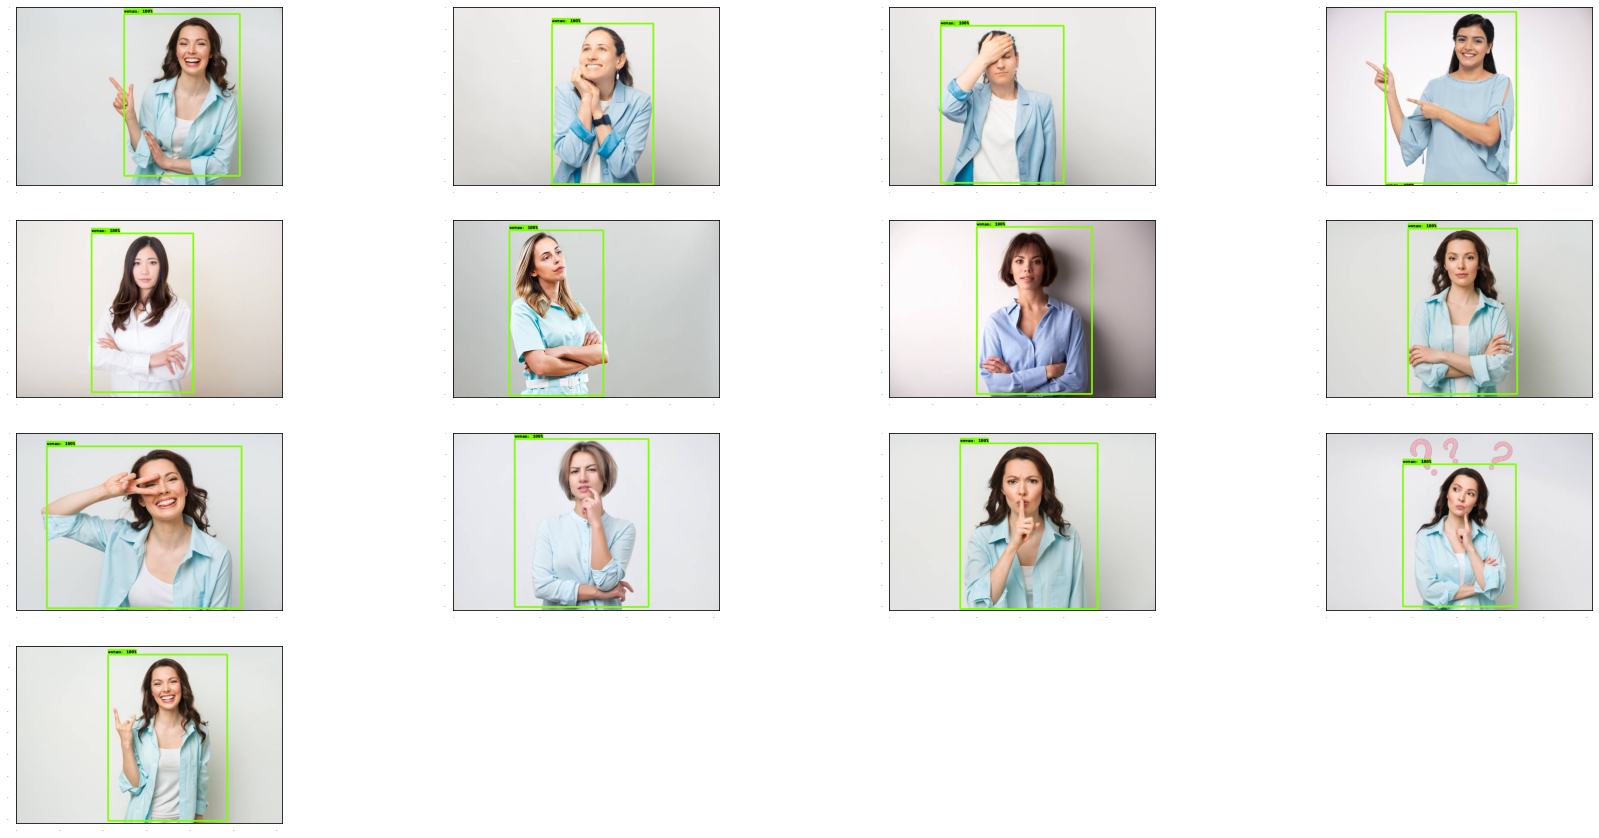

In [ ]:
dummy_scores = np.array([1], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))

for idx in range(len(gt_boxes)):
  plt.subplot(4, 4, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
  
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all except the classification layer at the top 

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-08-14 05:52:00--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.112.128, 2607:f8b0:4001:c12::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.112.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   170MB/s    in 1.4s    

2022-08-14 05:52:01 (170 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one 
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)

ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)

ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

prediction_dict = detection_model.predict(image, shapes)

_ = detection_model.postprocess(prediction_dict, shapes)

print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)


batch_size =4
learning_rate = 0.01
num_batches = 50

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables

to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
       

    Returns:
      A scalar tensor :..>>total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)

      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      gradients = tape.gradient(total_loss, vars_to_fine_tune)

      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

train_step_fn = get_model_train_step_function(
                        detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 50, loss=1.1916305
batch 10 of 50, loss=5.7597857
batch 20 of 50, loss=0.9367216
batch 30 of 50, loss=1.0520194
batch 40 of 50, loss=0.1475413


# Save our Models


In [ ]:
#os.chdir('/content/training_demo')
#os.getcwd()
#os.environ['CUDA_VISIBLE_DEVICES'] = "0"


In [ ]:
#%%bash

#cd /content/training_demo
#python exporter_main_v2.py --input_type image_tensor --pipeline_config_path .\models\my_ssd_resnet50_v1_fpn\pipeline.config --trained_checkpoint_dir .\models\my_ssd_resnet50_v1_fpn\ --output_directory .\exported-models\my_model
#sudo python3 exporter_main_v2.py --input_type image_tensor --pipeline_config_path models/my_ssd_resnet50_v1_fpn/pipeline.config --trained_checkpoint_dir models/my_ssd_resnet50_v1_fpn/ --output_directory exported-models/my_model


In [ ]:
# %%shell

#python exporter_main_v2.py --input_type image_tensor --pipeline_config_path .\models\my_ssd_resnet50_v1_fpn\pipeline.config --trained_checkpoint_dir .\models\my_ssd_resnet50_v1_fpn\ --output_directory .\exported-models\my_model
#sudo python3 exporter_main_v2.py --input_type image_tensor --pipeline_config_path models/my_ssd_resnet50_v1_fpn/pipeline.config --trained_checkpoint_dir models/my_ssd_resnet50_v1_fpn/ --output_directory exported-models/my_model


# Test Images


In [ ]:
image_dir = '/content/women/test'

# number of pictur 
test_pic = sorted(os.listdir(image_dir)) # dir is your directory path
number_pic_test = len(test_pic)
print(number_pic_test )
print(test_pic)


#copy model in Training Demo Folder

In [ ]:
#import shutil

#shutil.copyfile('/content/models/research/object_detection/exporter_main_v2.py', 
               # '/content/training_demo/exporter_main_v2.py' )

# Load test images and run inference with model

In [ ]:
#test_image_dir = 'models/research/object_detection/test_images/ducky/test/'

test_image_dir= '/content/women/test'

test_images_np = []

for img in test_pic:

  # image_path = os.path.join(train_image_dir, 'pic' + str(i) + '.jpg')
    image_path = os.path.join(test_image_dir, img)
     
    test_images_np.append(np.expand_dims(
                          load_image_into_numpy_array(image_path), axis=0) )

"""
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))
"""


@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
     

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)

  prediction_dict = detection_model.predict(preprocessed_image, shapes)

  return detection_model.postprocess(prediction_dict, shapes)


label_id_offset = 1

for i in range(len(test_images_np)):
   input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
   detections = detect(input_tensor)

   print(detections.keys())
  #print(detections.scores)
 # print(detections)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
a=(detections.keys())
type(detections['num_detections'])
#detections

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
   image = imageio.imread(filename)
   images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))